In [14]:
import pandas as pd
import os

pasta_arquivos = "dados_acoes"  
data_corte = "2015-01-05"       # Data limite (quem começou depois, sai)

precos_dict = {}
contagem_excluidos = 0

print("Começando a montagem da matriz...")

# Varre todos os arquivos da pasta
arquivos = [f for f in os.listdir(pasta_arquivos) if f.endswith('.csv')]

for arquivo in arquivos:
    ticker = arquivo.replace(".csv", "") # Tira o .csv do nome
    
    # Lê o arquivo da ação
    caminho_completo = os.path.join(pasta_arquivos, arquivo)
    df_temp = pd.read_csv(caminho_completo)
    
    # Converte data e define índice
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp = df_temp.set_index('Date')
    
    # Se a primeira data disponível for depois da data de corte, a empresa é muito nova.
    primeira_data = df_temp.index.min()
    
    if primeira_data <= pd.to_datetime(data_corte):
        # Aprovada! Guarda o preço de fechamento ajustado
        precos_dict[ticker] = df_temp['Adj Close']
    else:
        # Reprovada (IPO recente)
        print(f"Excluído: {ticker} (Começou em {primeira_data.date()})")
        contagem_excluidos += 1

# Consolidação
df_matriz = pd.DataFrame(precos_dict)

# Limpeza final: Remove dias que não tem dados (feriados ou furos)
df_matriz = df_matriz.dropna()

# Salva o arquivo final
df_matriz.to_csv("matriz_final_2015_2025.csv")

print("-" * 40)
print(f"✅ CONCLUÍDO!")
print(f"Total de arquivos lidos: {len(arquivos)}")
print(f"Empresas excluídas (novas demais): {contagem_excluidos}")
print(f"Empresas sobreviventes (Sua Carteira): {df_matriz.shape[1]}")
print(f"Arquivo salvo como: 'matriz_final_2015_2025.csv'")

Começando a montagem da matriz...
Excluído: PLTR (Começou em 2020-09-30)
Excluído: PYPL (Começou em 2015-07-06)
Excluído: UBER (Começou em 2019-05-10)
----------------------------------------
✅ CONCLUÍDO!
Total de arquivos lidos: 101
Empresas excluídas (novas demais): 3
Empresas sobreviventes (Sua Carteira): 98
Arquivo salvo como: 'matriz_final_2015_2025.csv'


In [15]:
# Para descobrir se temos ativos duplicados

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("matriz_final_2015_2025.csv", index_col="Date", parse_dates=True)

# Calcular a correlação
correlacao = df.corr()

# Buscar pares "gêmeos" (Correlação maior que 99%)
print("Procurando ativos duplicados/gêmeos...")
duplicados = []

for acao1 in correlacao.columns:
    for acao2 in correlacao.columns:
        if acao1 != acao2: # Não compara com ela mesma
            grau = correlacao.loc[acao1, acao2]
            if grau > 0.99: # Se for 99% igual, é suspeito
                pair = sorted([acao1, acao2])
                if pair not in duplicados:
                    duplicados.append(pair)
                    print(f"ALERTA DE GÊMEAS: {acao1} e {acao2} (Correlação: {grau:.4f})")

if not duplicados:
    print("Nenhuma ação duplicada encontrada! A ase está limpa.")
else:
    print("-" * 30)
    print(f"Total de pares duplicados/gêmeos encontrados: {len(duplicados)}")

Procurando ativos duplicados/gêmeos...
ALERTA DE GÊMEAS: GOOG e GOOGL (Correlação: 0.9999)
ALERTA DE GÊMEAS: MA e V (Correlação: 0.9967)
------------------------------
Total de pares duplicados/gêmeos encontrados: 2


In [16]:
import pandas as pd

df = pd.read_csv("matriz_final_2015_2025.csv", index_col="Date", parse_dates=True)

# Vamos remover: GOOGL (Alphabet) e MA (Mastercard)
removidas = ['GOOGL', 'MA']

# Remove as colunas
df_limpo = df.drop(columns=removidas, errors='ignore') # 'ignore' evita erro se já tiver tirado

# Salva o arquivo pronto para o Markowitz
df_limpo.to_csv("matriz_final_v2.csv")

print(f"Limpeza concluída!")
print(f"Removidas: {removidas}")
print(f"Total de ativos agora: {df_limpo.shape[1]}")
print("Pronto para rodar o Markowitz com o arquivo 'matriz_final_v2.csv'!")

Limpeza concluída!
Removidas: ['GOOGL', 'MA']
Total de ativos agora: 96
Pronto para rodar o Markowitz com o arquivo 'matriz_final_v2.csv'!


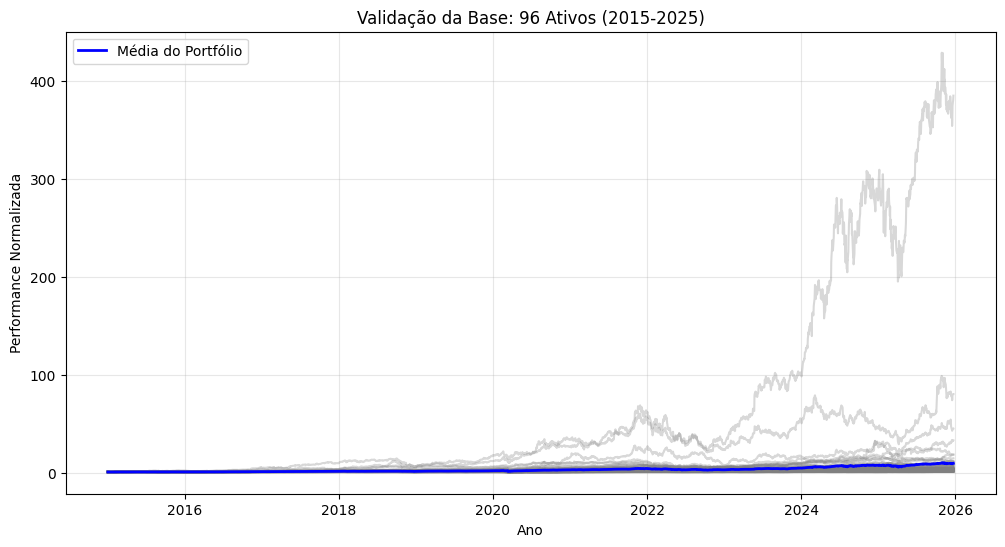

O outlier é: NVDA
Ela multiplicou o capital por 384.84 vezes.


In [17]:
# Validação visual dos dados

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("matriz_final_v2.csv", index_col="Date", parse_dates=True)

# Normaliza para tudo começar em 1 (para o gráfico ficar comparável)
# É possível ver se tem algum dado bizarro ou algum buraco
df_norm = df / df.iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(df_norm, alpha=0.3, color='gray') # Todas as ações em cinza
plt.plot(df_norm.mean(axis=1), color='blue', linewidth=2, label='Média do Portfólio') # A média em destaque
plt.title(f"Validação da Base: {len(df.columns)} Ativos (2015-2025)")
plt.xlabel("Ano")
plt.ylabel("Performance Normalizada")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("validacao_dados.png") # Salva pra você mandar
plt.show()

# Pega o valor acumulado no último dia
retorno_total = df_norm.iloc[-1]

# Descobre quem é o máximo
nome_max = retorno_total.idxmax()
quanto_cresceu = retorno_total.max()

print(f"O outlier é: {nome_max}")
print(f"Ela multiplicou o capital por {quanto_cresceu:.2f} vezes.")